In [1]:
!pip install pytubefix
!pip install moviepy
!pip install -U openai-whisper
!pip install ffmpeg
!pip install setuptools-rust

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.3/388.3 kB 8.5 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 62.7 MB/s eta 0:00:00:00:0100:01
  Created wheel for moviepy: filename=moviepy-1.0.3-py3-none-any.whl size=110720 sha256=38cab088522a5451c4ae488ebff7e668ea421b051eeb7598643d94cdd7c0540f
  Stored in directory: /root/.cache/pip/wheels/96/32/2d/e10123bd88fbfc02fed53cc18c80a171d3c87479ed845fa7c1
Successfully built moviepy
  Attempting uninstall: decorator
    Found existing installation: decorator 5.1.1
    Uninstalling decorator-5.1.1:
      Successfully uninstalled decorator-5.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.3.1 requires aiohttp!=4.0.0a0,!=4.0.0a1, which is not installed.
   

## Download Video using Pytube

In [2]:
from pytubefix import YouTube

video_link="https://www.youtube.com/watch?v=sHWsE1WnfyA"

try: 
    yt = YouTube(video_link) 
except: 
    print("Connection Error") 

stream = yt.streams.filter(res="360p").first()
stream.download("./Downloads/")

# This downloads the mp4 video in the specified path.

'/kaggle/working/Downloads/K Annamalai On PM Modi NDAs Chances & Why Jayalalitha Was A Much Superior Hindu.mp4'

## Generate Audio file for the Video using moviepy editor

In [3]:
import moviepy.editor
video = moviepy.editor.VideoFileClip("./Downloads/K Annamalai On PM Modi NDAs Chances & Why Jayalalitha Was A Much Superior Hindu.mp4")
audio = video.audio
audio.write_audiofile("audio_file.mp3")

# MoviePy helps in extracting the audio file from the video.

MoviePy - Writing audio in audio_file.mp3


MoviePy - Done.


## Transcribe the Audio using OpenAI's Whisper model
## Also generate segments of audio with timestamps

In [4]:
import torch
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
import whisper

model = whisper.load_model("base", DEVICE)
# Whisper Base model was used for transcription

result = model.transcribe("audio_file.mp3")
# result variable stores transcription and segment information of the audio. 

100%|███████████████████████████████████████| 139M/139M [00:03<00:00, 47.8MiB/s]


In [6]:
segments=[]
data=[]
for i in result["segments"]:
    segments.append(i['text'])
    data.append([i["id"], i['start'], i['end'], i['text']])

# This stores the information regarding segmentation performed by Whisper Base Model

In [7]:
data[:10] # The first 10 segments broken by Whisper model can be visualised.

[[0,
  0.0,
  2.88,
  ' Shall I start off by wishing you a happy birthday in advance?'],
 [1, 2.88, 3.88, ' Thank you sir.'],
 [2, 3.88, 6.48, ' So we can, two weeks in advance.'],
 [3,
  6.48,
  10.44,
  ' We can only offer you words, but do you think the people of Coembatore are going to'],
 [4, 10.44, 12.08, ' offer you more than words?'],
 [5,
  12.08,
  19.8,
  ' Yes, all elections are, you have to wait till the counting to know what people have decided.'],
 [6,
  19.8,
  24.48,
  ' But having said it, I always believe in election, you do your best and during the course of'],
 [7,
  24.48,
  28.88,
  ' a campaigning, you actually pick up a certain vibration and that is unmistakable.'],
 [8,
  28.88,
  32.44,
  ' An election normally, many a time you know the word it slightly previously sir, because'],
 [9, 32.44, 35.68, " the vibrations and people's body language do not lie."]]

## For semantic analysis of the text, generate BERT embeddings and merge the segments having high semantic similarity 

In [8]:
from transformers import BertTokenizer, BertModel
import torch

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# BERT Embeddings were used to calculate cosine similarity

def get_bert_embeddings(sentences):
    encoded = tokenizer.batch_encode_plus(sentences, add_special_tokens=True, padding='longest', return_tensors='pt')
    input_ids = encoded['input_ids']

    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_state = outputs[0] 
    sentence_embeddings = torch.mean(last_hidden_state, dim=1)

    return sentence_embeddings

embeddings = get_bert_embeddings(segments)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


In [9]:
import torch
from scipy.spatial.distance import cdist

cosine_similarities = []
start_time=0
chunk=[[]] # This variable stores all information of text in a chunk
for i in range(len(embeddings)-1):
    
    # The below code snippet avoids splitting of phrases over chunks. It was observed while splitting when segments started with a lowercase alphabet.
    # When lowercase alphabet is encountered, it is automatically included in the chunk and the similarity score might be lower due to embeddings.
    
    if(data[i][3][1].islower()):
        if(data[i][2]-start_time<15):
            chunk[len(chunk)-1].append(data[i])
        continue
        
    # Embeddings are extracted and cosine similarity is calculated between them to get semantic similarity score.
    
    emb1 = torch.tensor(embeddings[i])
    emb2 = torch.tensor(embeddings[i + 1])
    emb1 = emb1.reshape(1, -1)
    emb2 = emb2.reshape(1, -1)
    cosine_sim = round(1 - cdist(emb1, emb2, metric='cosine')[0][0], 1)
    
    # This threshold of 0.7 was dynamically chosen after observing the trend of cosine similarity scores, visualized in a graph ahead.
    
    if(cosine_sim>=0.7): 
        if(data[i][2]-start_time<15): # total chunk time is checked everytime before appending the segment into the chunk.
            chunk[len(chunk)-1].append(data[i])
        else:
            start_time=data[i][1]
            chunk.append([])
            chunk[len(chunk)-1].append(data[i])
    else: 
        start_time=data[i][1]
        chunk.append([])
        chunk[len(chunk)-1].append(data[i])
    
    cosine_similarities.append(cosine_sim) # This list stores cosine similarities used for visualization and threshold calculation

chunk.append([data[-1]]) # The final segment is included as a new chunk to avoid longer chunks, this might affect the quality slightly.
# print(len(chunk))

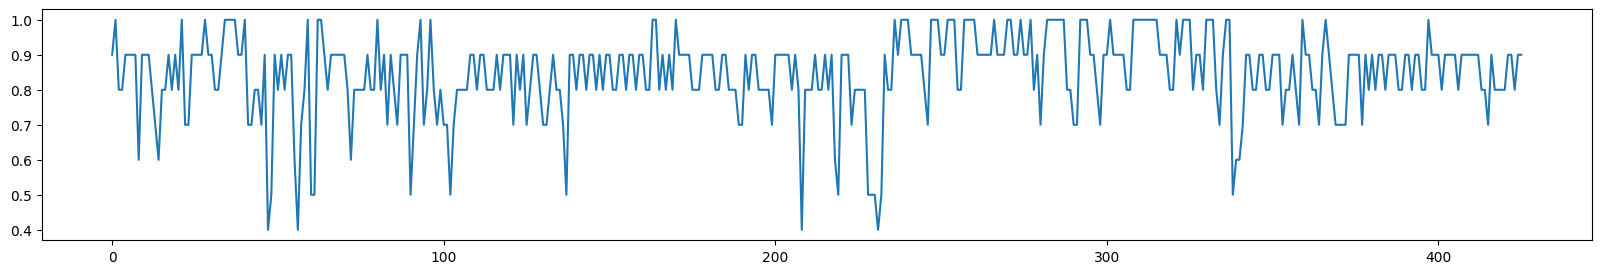

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 3))
plt.plot(cosine_similarities) # This plot helps in choosing the appropriate threshold value
plt.show()

In [11]:
final_chunks=[]

# This snippet helps in storing the chunks in the final format as expected.

for i in range(len(chunk)):
    text=[]
    for e in chunk[i]:
        text.append(e[3])
    final_chunks.append({
        "chunk_id": i+1,
        "chunk_length": round(chunk[i][-1][2]-chunk[i][0][1], 3),
        "text": "".join(text),
        "start_time": round(chunk[i][0][1],3),
        "end_time": round(chunk[i][-1][2],3)
    })

In [12]:
final_chunks[:5] # The first 5 chunks can be visualized

[{'chunk_id': 1,
  'chunk_length': 12.08,
  'text': ' Shall I start off by wishing you a happy birthday in advance? Thank you sir. So we can, two weeks in advance. We can only offer you words, but do you think the people of Coembatore are going to offer you more than words?',
  'start_time': 0.0,
  'end_time': 12.08},
 {'chunk_id': 2,
  'chunk_length': 12.4,
  'text': ' Yes, all elections are, you have to wait till the counting to know what people have decided. But having said it, I always believe in election, you do your best and during the course of',
  'start_time': 12.08,
  'end_time': 24.48},
 {'chunk_id': 3,
  'chunk_length': 10.16,
  'text': " An election normally, many a time you know the word it slightly previously sir, because the vibrations and people's body language do not lie. I think Coembatore we are in for historic verdicts, what I believe as of now.",
  'start_time': 28.88,
  'end_time': 39.04},
 {'chunk_id': 4,
  'chunk_length': 14.96,
  'text': ' I hope it will be a 

## Gradio app for the whole procedure

In [13]:
!pip install -q gradio

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.
distributed 2024.1.1 requires dask==2024.1.1, but you have dask 2024.5.1 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have google-cloud-storage 1.44.0 which is incompatible.
kfp 2.5.0 requires urllib3<2.0.0, but you have urllib3 2.2.1 which is incompatible.
rapids-dask-dependency 24.4.1a0 requires dask==2024.1.1, but you have dask 2024.5.1 which is incompatible.
rapids-dask-dependency 24.4.1a0 requires dask-expr==0.4.0, but you have dask-expr 1.1.1 which is incompatible.
spacy 3.7.3 requires typer<0.10.0,>=0.3.0, but you have typer 0.12.3 which is incompatible.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
weasel 0.3.4 requires typer<0.10.0,>=0.3.0, bu

In [14]:
# This code snippet wraps the whole code in a Gradio app, where input is a url to the video and output is the transcribed audio broken into chunks.

import gradio as gr
from pytubefix import YouTube
import moviepy.editor
import torch
import whisper
from transformers import BertTokenizer, BertModel
import torch
import torch
from scipy.spatial.distance import cdist

model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

def get_bert_embeddings(sentences):
    encoded = tokenizer.batch_encode_plus(sentences, add_special_tokens=True, padding='longest', return_tensors='pt')
    input_ids = encoded['input_ids']

    with torch.no_grad():
        outputs = model(input_ids)
        last_hidden_state = outputs[0] 

    sentence_embeddings = torch.mean(last_hidden_state, dim=1)

    return sentence_embeddings

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


def process_video_url(url):

    video_link=url
    yt = YouTube(video_link)  

    stream = yt.streams.filter(res="360p").first()
    stream.download("Downloads/")
    
    video = moviepy.editor.VideoFileClip("./Downloads/K Annamalai On PM Modi NDAs Chances & Why Jayalalitha Was A Much Superior Hindu.mp4")
    audio = video.audio
    audio.write_audiofile("audio_file.mp3")
    
    model = whisper.load_model("base", DEVICE)
    result = model.transcribe("audio_file.mp3")
    
    segments=[]
    data=[]
    for i in result["segments"]:
        segments.append(i['text'])
        data.append([i["id"], i['start'], i['end'], i['text']])
    
    embeddings = get_bert_embeddings(segments)
    
    adjacent_similarities = []
    start_time=0
    chunk=[[]]
    for i in range(len(embeddings)-1):
        if(data[i][3][1].islower()):
            if(data[i][2]-start_time<15):
                chunk[len(chunk)-1].append(data[i])
            continue
        emb1 = torch.tensor(embeddings[i])
        emb2 = torch.tensor(embeddings[i + 1])

        emb1 = emb1.reshape(1, -1)
        emb2 = emb2.reshape(1, -1)
        cosine_sim = round(1 - cdist(emb1, emb2, metric='cosine')[0][0], 1)
        if(cosine_sim>=0.7): 
            if(data[i][2]-start_time<15):
                chunk[len(chunk)-1].append(data[i])
            else:
                start_time=data[i][1]
                chunk.append([])
                chunk[len(chunk)-1].append(data[i])
        else: 
            start_time=data[i][1]
            chunk.append([])
            chunk[len(chunk)-1].append(data[i])
       
    adjacent_similarities.append(cosine_sim)

    chunk[-1].append(data[-1])

    final_chunks=[]
    for i in range(len(chunk)):
        text=[]
        for e in chunk[i]:
            text.append(e[3])
        final_chunks.append({
            "chunk_id": i+1,
            "chunk_length": round(chunk[i][-1][2]-chunk[i][0][1], 3),
            "text": "".join(text),
            "start_time": round(chunk[i][0][1],3),
            "end_time": round(chunk[i][-1][2],3)
        })

    return final_chunks

gr.Interface(fn=process_video_url,
             inputs='textbox',
             outputs='textbox').launch(share=True);

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://e522316d2aeae9118e.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Note: This notebook was observed to not transcribe the whole audio properly when run on Google Colab, and the Gradio app was observed to not work properly on Kaggle. 